# DEMO 

Read in the intake catalogues from the input to bias correction



#### required packages

In [1]:
import intake
import xarray as xr
from matplotlib import pyplot as plt

import glob
import pathlib
import traceback
from datetime import datetime

from xclim.indices import (
    keetch_byram_drought_index,
    griffiths_drought_factor,
    mcarthur_forest_fire_danger_index
)


#### start a local Dask client

In [2]:
from dask.distributed import Client
import dask

# Set configuration options
dask.config.set({
    'distributed.comm.timeouts.connect': '90s',  # Timeout for connecting to a worker
    'distributed.comm.timeouts.tcp': '90s',  # Timeout for TCP communications
})

#cluster = LocalCluster(
#    n_workers=28,          # Number of workers
#    threads_per_worker=1 #Threads per worker
#    #memory_limit='8GB' # Memory limit per each worker commented out
#)
#client = Client(cluster)

client = Client()
client

2024-06-28 21:03:21,638 - distributed.preloading - INFO - Creating preload: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py
2024-06-28 21:03:21,642 - distributed.utils - INFO - Reload module schedplugin from .py file
2024-06-28 21:03:21,649 - distributed.preloading - INFO - Import preload module: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py


Modifying workers


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /node/gadi-mmem-bdw-0003.gadi.nci.org.au/60704/proxy/8787/status,
Dashboard: /node/gadi-mmem-bdw-0003.gadi.nci.org.au/60704/proxy/8787/status,Workers: 32
Total threads: 32,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41037,Workers: 32
Dashboard: /node/gadi-mmem-bdw-0003.gadi.nci.org.au/60704/proxy/8787/status,Total threads: 32
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:40877,Total threads: 1
Dashboard: /node/gadi-mmem-bdw-0003.gadi.nci.org.au/60704/proxy/39825/status,Memory: 0 B
Nanny: tcp://127.0.0.1:37105,


In [3]:
import warnings
warnings.filterwarnings('ignore')

## Obtain the desired catalogues of the simulations to processe

In [4]:
catalogue_path='/g/data/ia39/catalogues'
mRuns = sorted(glob.glob(catalogue_path+'/*ssp370*.json'))
mRuns = sorted(glob.glob(catalogue_path+'/*BARRA*.json'))
print(len(mRuns))

1


In [5]:
# test loading all the catalogues of the data
ifile=-1
for file in mRuns: 
    ifile=ifile+1
    print(ifile, file)
    cat1=intake.open_esm_datastore(file)
#    tmp = cat1.search(variable={'pr'}).to_dask(cdf_kwargs={'chunks': {'time': 365, 'lat': 691, 'lon': 886}})
#    print(ifile,len(tmp.time))



0 /g/data/ia39/catalogues/AGCD-05i_BOM_ERA5_historical_hres_BARRA-R2_v1_day.json


# Process one ensemble 

In [6]:
# From one catalogue list save variables
mindex=0  # run to process
cat=intake.open_esm_datastore(mRuns[mindex])
mtmp=mRuns[mindex].split('/')
model_name=mtmp[5].split('.')
print(model_name)
print(cat.unique()['variable']) #unique()['variable']
tmp=model_name[0].split('_'); ACS_model=tmp[1]

['AGCD-05i_BOM_ERA5_historical_hres_BARRA-R2_v1_day', 'json']
['hursmax', 'hursmin', 'pr', 'rsds', 'sfcWindmax', 'tasmax', 'tasmin']


In [8]:
%%time
pr = cat.search(variable={'pr'}).to_dask(cdf_kwargs={'chunks': {'time': 1, 'lat': 691, 'lon': 886}})
tasmax = cat.search(variable={'tasmax'}).to_dask(cdf_kwargs={'chunks': {'time': 1, 'lat': 691, 'lon': 886}})
hursmin = cat.search(variable={'hursmin'}).to_dask(cdf_kwargs={'chunks': {'time': 1, 'lat': 691, 'lon': 886}})
sfcWindmax = cat.search(variable={'sfcWindmax'}).to_dask(cdf_kwargs={'chunks': {'time': 1, 'lat': 691, 'lon': 886}})

# hursmin has a different time axis than the other variables!
# could do two seperate datasets to deal with the different tima axis but not doing now.
hursmin=hursmin.assign_coords(time= pr.time)

# BoM files have height coordinate in the sfcWindmax that needs to be removed
# these have been fixed
if ACS_model == 'BOM1':
    sfcWindmax=sfcWindmax.reset_coords('height', drop=True)
    tasmax=tasmax.reset_coords('height', drop=True)
    hursmin=hursmin.reset_coords({'height','level_height','model_level_number','sigma'}, drop=True)

CPU times: user 15.3 s, sys: 2.03 s, total: 17.3 s
Wall time: 21.4 s


In [9]:
ds=xr.merge([pr,tasmax,hursmin,sfcWindmax], compat='override')
ds

<xarray.Dataset>
Dimensions:     (time: 16436, lat: 691, lon: 886, bnds: 2)
Coordinates:
  * time        (time) datetime64[ns] 1979-01-01T12:00:00 ... 2023-12-31T12:0...
  * lat         (lat) float64 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon         (lon) float64 112.0 112.0 112.1 112.2 ... 156.2 156.2 156.2
    lat_bnds    (lat, bnds) float64 dask.array<chunksize=(691, 2), meta=np.ndarray>
    lon_bnds    (lon, bnds) float64 dask.array<chunksize=(886, 2), meta=np.ndarray>
  * bnds        (bnds) float64 0.0 1.0
    time_bnds   (time, bnds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
Data variables:
    pr          (time, lat, lon) float32 dask.array<chunksize=(1, 691, 886), meta=np.ndarray>
    tasmax      (time, lat, lon) float32 dask.array<chunksize=(1, 691, 886), meta=np.ndarray>
    hursmin     (time, lat, lon) float32 dask.array<chunksize=(1, 691, 886), meta=np.ndarray>
    sfcWindmax  (time, lat, lon) float32 dask.array<chunksize=(1, 691, 886), meta=np.ndarray>
Attributes: (12/51)
    Conventions:                         CF-1.10, ACDD-1.3
    activity_id:                         reanalysis
    title:                               Pre-processed model output in prepar...
    source:                              Data from Met Office Unified Model (...
    project:                             BARRA2
    program:                             Australian Climate Service (ACS)
    ...                                  ...
    intake_esm_attrs:downscale_model:    BOM
    intake_esm_attrs:downscale_version:  BARRA-R2
    intake_esm_attrs:period:             v1
    intake_esm_attrs:time_period:        fixed
    intake_esm_attrs:_data_format_:      netcdf
    intake_esm_dataset_key:              AGCD-05i.ERA5.historical.hres.BOM.BA...

In [10]:
print(len(pr.time))

16436


In [11]:
from rechunker import rechunk

max_mem = "4GB"
max_mem = "8GB"  # worked for normal que xxlarge
max_mem = "18GB"  # worked for Megamem
max_mem = "50GB"  # could try (30 fast but file had errors for mindex=1 - now with Megamem

# all files have different time sizes!!!
target_chunks = {"time": 31025, "lat": 33, "lon": 43}
target_chunks = {"time": 31411, "lat": 33, "lon": 43}

# remove existing zarr files
!rm -rf /scratch/xv83/rxm599/tmp.zarr 
target_store = "/scratch/xv83/rxm599/"+model_name[0]+".zarr"
temp_store = "/scratch/xv83/rxm599/tmp.zarr"
!rm -rf {target_store}
print(target_store)

/scratch/xv83/rxm599/AGCD-05i_BOM_ERA5_historical_hres_BARRA-R2_v1_day.zarr


In [12]:
array_plan = rechunk(ds
    , target_chunks, max_mem, target_store, temp_store=temp_store )


In [13]:
%%time
array_plan.execute()

CPU times: user 5min 20s, sys: 45.1 s, total: 6min 5s
Wall time: 9min 48s


<zarr.hierarchy.Group '/'>

# Extra plotting of written file

If any of these variables have nan than the FFDI calculation will fail

In [14]:
target_store = "/scratch/xv83/rxm599/"+model_name[0]+".zarr"
ds0=xr.open_zarr(target_store)
ds0

0.3.0


<xarray.Dataset>
Dimensions:     (bnds: 2, time: 16436, lat: 691, lon: 886)
Coordinates:
  * bnds        (bnds) float64 0.0 1.0
  * lat         (lat) float64 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
    lat_bnds    (lat, bnds) float64 dask.array<chunksize=(33, 2), meta=np.ndarray>
  * lon         (lon) float64 112.0 112.0 112.1 112.2 ... 156.2 156.2 156.2
    lon_bnds    (lon, bnds) float64 dask.array<chunksize=(43, 2), meta=np.ndarray>
  * time        (time) datetime64[ns] 1979-01-01T12:00:00 ... 2023-12-31T12:0...
    time_bnds   (time, bnds) datetime64[ns] dask.array<chunksize=(16436, 2), meta=np.ndarray>
Data variables:
    hursmin     (time, lat, lon) float32 dask.array<chunksize=(16436, 33, 43), meta=np.ndarray>
    pr          (time, lat, lon) float32 dask.array<chunksize=(16436, 33, 43), meta=np.ndarray>
    sfcWindmax  (time, lat, lon) float32 dask.array<chunksize=(16436, 33, 43), meta=np.ndarray>
    tasmax      (time, lat, lon) float32 dask.array<chunksize=(16436, 33, 43), meta=np.ndarray>
Attributes: (12/51)
    Conventions:                         CF-1.10, ACDD-1.3
    acknowledgement:                     The production of BARRA2 was support...
    activity_id:                         reanalysis
    contact:                             Bureau of Meteorology (data_governan...
    creator_institution:                 Bureau of Meteorology
    creator_type:                        institution
    ...                                  ...
    source_id:                           BARRA-R2
    standard_name_vocabulary:            CF Standard Name Table v79
    summary:                             The Bureau of Meteorology Atmospheri...
    title:                               Pre-processed model output in prepar...
    variable_id:                         pr
    version_realisation:                 v1

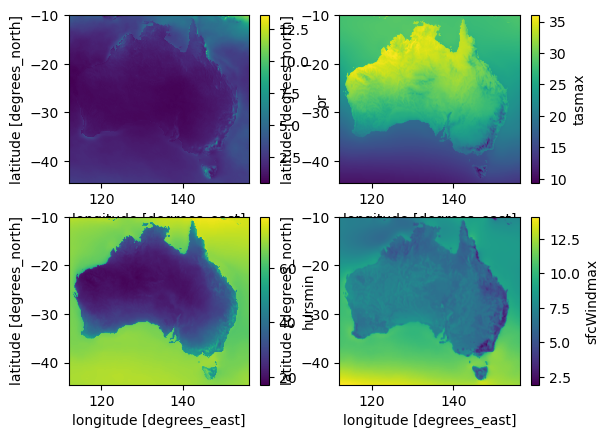

In [15]:
t1='2015-01-01'; t2='2099-12-31'
pra=ds0.pr.sel(time=slice(t1, t2))
tasmaxa=ds0.tasmax.sel(time=slice(t1,t2))
hursmina=ds0.hursmin.sel(time=slice(t1,t2))
sfcWindmaxa=ds0.sfcWindmax.sel(time=slice(t1,t2))

plt.subplot(2,2,1); pra.mean('time',skipna=False).plot()
plt.subplot(2,2,2); tasmaxa.mean('time',skipna=False).plot()
plt.subplot(2,2,3); hursmina.mean('time',skipna=False).plot()
plt.subplot(2,2,4); sfcWindmaxa.mean('time',skipna=False).plot()

In [16]:
nan_count = pra.isel(time=slice(0,None),lon=140,lat=-30).isnull().sum().compute().item()
print(nan_count)

0


In [17]:
nan1=pra.isnull().sum().compute().item()
print(nan1)
nan2=sfcWindmaxa.isnull().sum().compute().item()
print(nan2)
nan3=tasmaxa.isnull().sum().compute().item()
print(nan3)
nan4=hursmina.isnull().sum().compute().item()
print(nan4)
print(nan1,nan2,nan3,nan4)

0
0
0
0
0 0 0 0


In [18]:
print(691*886*2)

1224452


In [19]:
# Find the indices of NaN values
def nan_var(var):
    nan_mask = var.isel(time=slice(0,None),lon=140,lat=-30).isnull().compute()
    nan_indices = nan_mask.where(nan_mask, drop=True).time
    print(f"Indices of NaN values in :\n{nan_indices.values}")

nan_var(tasmaxa)

Indices of NaN values in :
[]


In [ ]:
client.shutdown()